In [1]:
import os
import numpy as np
import seaborn as sns
import scanpy as sc
import matplotlib.pyplot as plt
import time
import pandas as pd

from PIL import Image
import cv2


In [2]:
# !pip install opencv-python
# !conda install -c conda-forge pygis

In [3]:
import sys
sys.path.append('../../')

from downstream.svg import detect_svg
from downstream.plotting import svgplot
import downstream.edge

import utils

In [23]:
# set global rc parameters
# sc.settings.set_figure_params(vector_friendly=True)

utils.config_rc(dpi=300, font_size=6)
# mpl.rcParams
wk_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))

# IDC data result root path
data_root = utils.get_path('cci_wk_root', json_path=os.path.join(wk_root, '_data.json'))

In [5]:
adata = sc.read_h5ad(os.path.join(data_root, 'IDC/IDC_w_anno.h5ad'))

In [6]:
adata

AnnData object with n_obs × n_vars = 4727 × 19437
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'SpaSEG_discrete_clusters', 'SpaSEG_clusters', 'spot_neighbors', 'annotation'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'SpaSEG_clusters_colors', 'metrics', 'pca', 'raw_domain_lr_means', 'spatial', 'spatial_neighbors'
    obsm: 'X_pca', 'cell2loc', 'cell_types', 'spatial', 'spot_lr_padj', 'spot_lr_score'
    varm: 'PCs'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [7]:
# get spot size 
spot_size = adata.uns['spatial']['V1_Human_Invasive_Ductal_Carcinoma']['scalefactors']['spot_diameter_fullres']
scalef = adata.uns['spatial']['V1_Human_Invasive_Ductal_Carcinoma']['scalefactors']['tissue_hires_scalef']

In [8]:
# we only demostrate domain 0,2,8 (invisive)
tumor_map={0:1, 2:1,3:0,8:1,9:0, 1:0,5:0,7:0, 6: 0, 4:0}
coords=adata.obsm['spatial']

# scale coords (10x data)
x_coords = (coords[:,0]/(spot_size*0.2)).astype(int)
y_coords = (coords[:,1]/(spot_size*0.2)).astype(int)
img=np.zeros((max(y_coords)+1,max(x_coords)+1))
img[y_coords,x_coords]=adata.obs['SpaSEG_clusters'].map(tumor_map)
img_map = (img*255).astype(np.uint8)
# Image.fromarray(img_map)

In [9]:
area, boundary = edge.find_boundary(img_map, min_thre_binary=200, 
                 max_thre_binary=255, 
                 gaussian_sigma=10, 
                 canny_thre1=80, 
                 canny_thre2=160,se_ksize=17)

In [11]:
smoothed_b = edge.smooth_boundary(img_map,[boundary[0]], factor=0.00198,sm_ksize=17) # 0.001

In [13]:
smoothed_cout = (smoothed_b[0]*spot_size*0.2).astype(int)
print('smoothed_cout.shape:', smoothed_cout.shape)
sq_smoothed_cout = smoothed_cout.squeeze()

smoothed_cout.shape: (347, 1, 2)


In [14]:
mid_x = (sq_smoothed_cout[:,0].max()-sq_smoothed_cout[:,0].min())/1.2
mid_y = (sq_smoothed_cout[:,1].max()-sq_smoothed_cout[:,1].min())/10
keeped_points=[]
for i,j in sq_smoothed_cout:
    if not ((i>(mid_x+sq_smoothed_cout[:,0].min()) or i< sq_smoothed_cout[:,0].min()+50) and j>(mid_y+sq_smoothed_cout[:,1].min())):
        keeped_points.append([i,j])
keeped_points = np.array(keeped_points)


In [15]:
sorted_keeped_points=keeped_points[keeped_points[:, 0].argsort()]

unwanted_point_ind = list(range(43,52))+list(range(151,178))+[len(sorted_keeped_points)-1]
final_points = np.delete(sorted_keeped_points, np.s_[unwanted_point_ind],0)

In [16]:
import shapely
from shapely.geometry import LineString, GeometryCollection, Point, Polygon
from shapely.plotting import plot_line, plot_polygon

borderline = LineString(final_points)

In [18]:
def find_distance_border(final_points, distance):
    # https://github.com/shapely/shapely/issues/1089
    borderline = LineString(final_points)
    buff = borderline.buffer(distance, resolution=10, single_sided=False,cap_style=3, join_style=1,mitre_limit=5, quad_segs=3)

    line_split_collection=[]
    line_split_collection.append(buff.boundary)
    merged_lines = shapely.ops.linemerge(line_split_collection)
    border_lines = shapely.ops.unary_union(merged_lines)

    splitter1 = LineString([(final_points[0,0], final_points[0,1] - distance * 3), 
                            (final_points[0,0], final_points[0,1] + distance * 3)])


    # fig,ax = plt.subplots(figsize=(1.5,1.5))
    # plot_line(borderline, color="r", ax=ax,add_points=False, linewidth=0.5)
    # plot_line(border_lines,color="green", ax=ax,linewidth=0.5, add_points=False)
    # plot_line(splitter1, ax=ax,linewidth=0.5,add_points=False)

    ##################
    # first split
    out1=edge.complex_split(border_lines, splitter1)
    # print('len(out1.geoms): ', len(out1.geoms))

    # this is to merge separate borderlines together
    keeped_borders = shapely.ops.linemerge([out1.geoms[0], out1.geoms[2]])

    # plot_line(out1.geoms[1],color="y",ax=ax,linewidth=0.5, add_points=False)
    # plot_line(keeped_borders,color="k",ax=ax,linewidth=0.5, add_points=False)

    # second split
    splitter2 = LineString([(final_points[-1,0], final_points[-1,1] - distance*3), 
                        (final_points[-1,0], final_points[-1,1] + distance*3)])
    out2=edge.complex_split(keeped_borders, splitter2)
    # plot_line(splitter2, ax=ax,linewidth=0.5,add_points=False)
    # plot_line(out2.geoms[0],color="red",ax=ax,linewidth=0.5,add_points=False)
    # plot_line(out2.geoms[1],color="blue",ax=ax,linewidth=0.5,add_points=False)
    # plot_line(out2.geoms[2],color="k",ax=ax,linewidth=0.5,add_points=False)

    # get valid border lines
    # positive, negative 
    # note: y coords is inverse to sc.pl.spatial()
    return out2.geoms[0], out2.geoms[2]



In [19]:
# find distance borders
distance4 = 5.5*spot_size # 4*55
pos_line4, neg_line4 = find_distance_border(final_points, distance4)

distance8 = 11*spot_size # 8*55
pos_line8, neg_line8 = find_distance_border(final_points, distance8)

In [20]:
# crt polygons
polygon_pos_8_4 = Polygon([*list(pos_line8.coords),*list(pos_line4.coords)[::-1]])
polygon_pos_4_borderline = Polygon([*list(pos_line4.coords),*list(borderline.coords)[::-1]])

polygon_borderline_neg_4 = Polygon([*list(borderline.coords),*list(neg_line4.coords)])
polygon_neg_4_8 = Polygon([*list(neg_line4.coords),*list(neg_line8.coords)[::-1]])


In [21]:
x_max, x_min = coords[:,0].max(), coords[:,0].min()
y_max, y_min = coords[:,1].max(), coords[:,1].min() 
x_part = (x_max - x_min)/10
y_part = (y_max - y_min)/10

x_left = x_part*4.5+x_min
x_right = x_part*7.5+x_min
y_buttom = y_part*3.7+y_min

y_top =  y_buttom+(x_right-x_left)

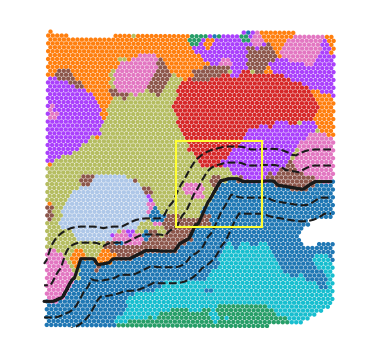

In [38]:
# plot
import matplotlib.patches as patches

fig,ax = plt.subplots(figsize=(3.5*utils.centimeter, 3.5*utils.centimeter))
sc.pl.spatial(adata, color='SpaSEG_clusters', title='', size=1.5,frameon = False, show=False, ax=ax, img_key=None,alpha=1)

lines = [pos_line8,pos_line4,neg_line4, neg_line8, borderline]
for i, _l in enumerate(lines):
    yy = np.asarray([x for x in list(_l.coords)])
    if i == len(lines)-1:
        ax.plot(yy[:,0],yy[:,1], color='k', linewidth=0.75)
    else:
        ax.plot(yy[:,0],yy[:,1], color='k', linestyle='--',linewidth=0.5)

# Create a Rectangle patch
rect = patches.Rectangle((x_left,y_buttom), x_right-x_left,  x_right-x_left, linewidth=0.5, edgecolor='#ffff33', facecolor='none',zorder=10)
# Add the patch to the Axes
ax.add_patch(rect)

ax.set_ylim([coords[:,1].max()+120,coords[:,1].min()-150])
ax.get_legend().remove()
plt.savefig(os.path.join(wk_root, f'notebook/results/IDC/border.pdf'), bbox_inches='tight', format='pdf', dpi=400)

In [39]:
crop_adata = adata[(coords[:,0]<=x_right) & (coords[:,0]>=x_left) & (coords[:,1]>=y_buttom) & (coords[:,1]<=y_top)]

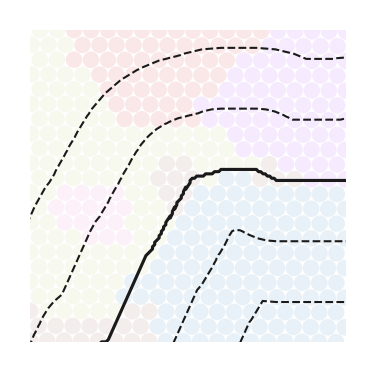

In [40]:
fig,ax = plt.subplots(figsize=(3.5*utils.centimeter, 3.5*utils.centimeter))
sc.pl.spatial(crop_adata, color='SpaSEG_clusters', title='', size=1.5,frameon = False, show=False, ax=ax, img_key=None,alpha=0.1)

for i, _l in enumerate(lines):
    yy = np.asarray([x for x in list(_l.coords)])
    if i == len(lines)-1:
        ax.plot(yy[:,0],yy[:,1], color='k', linewidth=0.75)
    else:
        ax.plot(yy[:,0],yy[:,1], color='k', linestyle='--',linewidth=0.5)

ax.get_legend().remove()
ax.set_ylim([crop_adata.obsm['spatial'][:,1].max(),crop_adata.obsm['spatial'].min()])
ax.set_xlim([crop_adata.obsm['spatial'][:,0].min(),crop_adata.obsm['spatial'][:,0].max()])
plt.savefig(os.path.join(wk_root, f'notebook/results/IDC/border_zoomin.pdf'), bbox_inches='tight', format='pdf', dpi=400)

In [202]:
# save borders
import pickle

# with open(os.path.join(wk_root, f'notebook/results/IDC/borderlines.pkl'), 'wb') as f:
#     pickle.dump(lines, f)
    
with open(os.path.join(wk_root, f'notebook/results/IDC/borderlines.pkl'), 'rb') as f:
    lines = pickle.load(f)  # [pos_line8,pos_line4,neg_line4, neg_line8, borderline]


In [136]:
# get coords in regions

# first exclude domain domain 3 and domain 9
df_ct_frac = adata.obsm['cell2loc'].copy()
df_ct_frac = df_ct_frac.div(df_ct_frac.sum(axis=1), axis=0)
adata.obsm['cell2loc_frac'] = df_ct_frac

_adata = adata.copy()
_adata = _adata[~_adata.obs['SpaSEG_clusters'].isin([3,9,6,4])]  

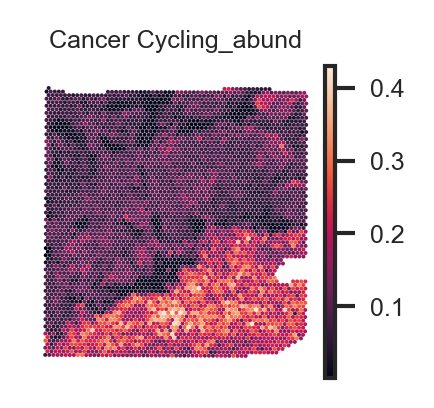

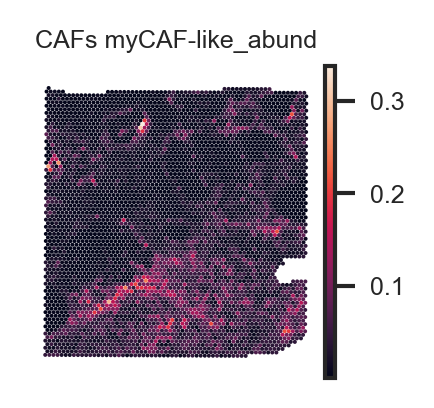

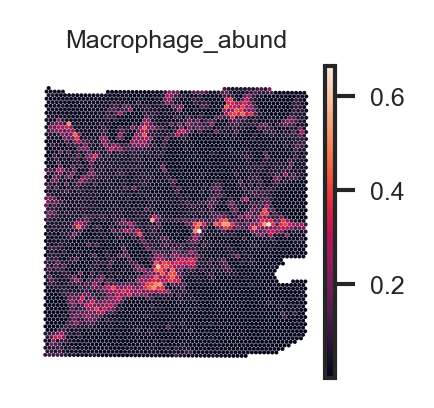

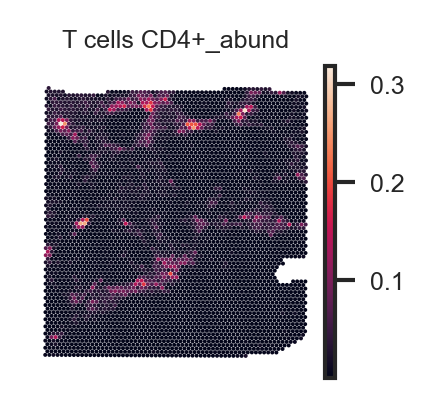

In [257]:
cts = ['Cancer Cycling','CAFs myCAF-like','Macrophage', 'T cells CD4+']
for _ct in cts:
    adata.obs[_ct+'_abund'] = adata.obsm['cell2loc_frac'][_ct]
    fig,ax = plt.subplots(figsize=(3.5*utils.centimeter, 3.5*utils.centimeter))
    sc.pl.spatial(adata, color=_ct+'_abund', title=_ct+'_abund', size=1.5,frameon = False, show=False, ax=ax, img_key=None,alpha=1)
    plt.savefig(os.path.join(wk_root, f'notebook/results/IDC/celltype_dist_{_ct}.pdf'), bbox_inches='tight', format='pdf', dpi=400)

In [137]:
_adata

View of AnnData object with n_obs × n_vars = 3092 × 19437
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'SpaSEG_discrete_clusters', 'SpaSEG_clusters', 'spot_neighbors', 'annotation'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'SpaSEG_clusters_colors', 'metrics', 'pca', 'raw_domain_lr_means', 'spatial', 'spatial_neighbors'
    obsm: 'X_pca', 'cell2loc', 'cell_types', 'spatial', 'spot_lr_padj', 'spot_lr_score', 'cell2loc_frac'
    varm: 'PCs'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [138]:
_adata.obsm['cell2loc_frac'].columns

Index(['B cells Memory', 'B cells Naive', 'CAFs MSC iCAF-like',
       'CAFs myCAF-like', 'Cancer Basal SC', 'Cancer Cycling',
       'Cancer Her2 SC', 'Cancer LumA SC', 'Cancer LumB SC', 'Cycling PVL',
       'Cycling T-cells', 'Cycling_Myeloid', 'DCs', 'Endothelial ACKR1',
       'Endothelial CXCL12', 'Endothelial Lymphatic LYVE1', 'Endothelial RGS5',
       'Luminal Progenitors', 'Macrophage', 'Mature Luminal', 'Monocyte',
       'Myoepithelial', 'NK cells', 'NKT cells', 'PVL Differentiated',
       'PVL Immature', 'Plasmablasts', 'T cells CD4+', 'T cells CD8+'],
      dtype='object')

In [139]:
coords = _adata.obsm['spatial']
coords_pt = list(map(Point, zip(coords[:,0],coords[:,1])))

def get_pt_in_region(coords_pt, region):
    return np.array([1 if region.contains(i) else 0 for i in coords_pt])


In [140]:
pt_in_pos_8_4 = get_pt_in_region(coords_pt, polygon_pos_8_4)
pt_in_pos_4_borderline = get_pt_in_region(coords_pt, polygon_pos_4_borderline)
pt_in_borderline_neg_4 = get_pt_in_region(coords_pt, polygon_borderline_neg_4)
pt_in_neg_4_8 = get_pt_in_region(coords_pt, polygon_neg_4_8)

In [141]:
adata_p84 = _adata[pt_in_pos_8_4==1,:] 
adata_p4b = _adata[pt_in_pos_4_borderline==1,:]
adata_bn4 = _adata[pt_in_borderline_neg_4==1,:]
adata_n48 = _adata[pt_in_neg_4_8==1,:]


In [142]:
adas = [adata_p84, adata_p4b, adata_bn4, adata_n48]
dist_lab = ['8-4','4-b','b--4','-4--8']

In [143]:
# for i, ada in enumerate(adas):
#     ada.to_df().to_csv(os.path.join(wk_root, f'notebook/results/IDC/border_adata_expr_{dist_lab[i]}.csv'))

In [144]:

df_cell_type_frac_regs=None
for i, ada in enumerate(adas):
    if i==0:
        df_cell_type_frac = ada.obsm['cell2loc_frac'].copy()
        df_cell_type_frac['region'] = [dist_lab[i]] * df_cell_type_frac.shape[0]
        df_cell_type_frac_regs = df_cell_type_frac
    else:
        df_cell_type_frac1 = ada.obsm['cell2loc_frac'].copy()
        df_cell_type_frac1['region'] = [dist_lab[i]] * df_cell_type_frac1.shape[0]
        df_cell_type_frac_regs = pd.concat([df_cell_type_frac_regs, df_cell_type_frac1], ignore_index=True)

In [145]:
df_cell_type_frac_regs

,B cells Memory,B cells Naive,CAFs MSC iCAF-like,CAFs myCAF-like,Cancer Basal SC,Cancer Cycling,Cancer Her2 SC,Cancer LumA SC,Cancer LumB SC,Cycling PVL,...,Monocyte,Myoepithelial,NK cells,NKT cells,PVL Differentiated,PVL Immature,Plasmablasts,T cells CD4+,T cells CD8+,region
0,0.005344,0.012767,0.002247,0.020149,0.082667,0.157942,0.091770,0.176522,0.127056,0.000621,...,0.007239,0.051800,0.001531,0.000294,0.002571,0.000628,0.000550,0.001145,0.000379,8-4
1,0.000777,0.003752,0.000165,0.013823,0.097554,0.143440,0.117441,0.209384,0.179617,0.000460,...,0.000353,0.033166,0.000750,0.000133,0.001405,0.000311,0.000046,0.000356,0.000152,8-4
2,0.001067,0.001788,0.000154,0.040597,0.078028,0.349638,0.075660,0.184352,0.073970,0.000941,...,0.001339,0.040212,0.001888,0.000360,0.000811,0.000413,0.000133,0.000185,0.000177,8-4
3,0.000955,0.000650,0.000316,0.041427,0.068370,0.384617,0.058191,0.211084,0.030324,0.001090,...,0.000945,0.063396,0.000687,0.000169,0.000860,0.000341,0.002481,0.000218,0.000279,8-4
4,0.000263,0.001078,0.000101,0.029967,0.092086,0.262447,0.087387,0.220120,0.110731,0.001081,...,0.000420,0.050346,0.000884,0.000128,0.001527,0.000188,0.000089,0.000255,0.000191,8-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,0.001515,0.000232,0.002814,0.017393,0.077776,0.138180,0.103842,0.227400,0.155931,0.001043,...,0.001213,0.007306,0.001686,0.004770,0.004391,0.002216,0.030135,0.005277,0.003597,-4--8
971,0.000954,0.000167,0.002133,0.023328,0.099555,0.162608,0.123039,0.195791,0.158514,0.000227,...,0.001392,0.030985,0.000592,0.000364,0.002741,0.001564,0.009841,0.000738,0.000456,-4--8
972,0.002765,0.000673,0.007243,0.039796,0.083231,0.134694,0.083144,0.174597,0.100497,0.001907,...,0.002476,0.034274,0.001422,0.011565,0.007797,0.004646,0.051157,0.009940,0.002821,-4--8
973,0.006583,0.003022,0.007184,0.052114,0.066559,0.063191,0.111935,0.128504,0.092926,0.001515,...,0.004116,0.014109,0.001270,0.009621,0.001424,0.002012,0.124226,0.015026,0.007605,-4--8


In [214]:
from statannotations.Annotator import Annotator


def _boxplot(data, x, y, ax, comp_pairs,
             orient='v', orders=None,fontsize=6,
             showfliers=False, linewidth=0.5, width=0.7, gene=False,
             bg_f = ['#b9f2f0', '#ffb482', '#8de5a1', '#ff9f9b', '#d0bbff', '#debb9b', '#fab0e4', '#fffea3'],
            ln_f = ['#00d7ff', '#ff7c00', '#1ac938', '#e8000b', '#8b2be2', '#9f4800', '#f14cc1', '#ffc400']):
    
    if orders is None:
        orders = data.x.unique()
    
    # from matplotlib import cm, colors
    # x = list(map(colors.to_hex, sns.color_palette('pastel')))
    # print(x)
    # x = list(map(colors.to_hex, sns.color_palette('bright')))
    # print(x)
    
    # light color from 'pastel'
    # bg_f = ['#b9f2f0', '#ffb482', '#8de5a1', '#ff9f9b', '#d0bbff', '#debb9b', '#fab0e4', '#fffea3']
    # bright color from 'bright'
    # ln_f = ['#00d7ff', '#ff7c00', '#1ac938', '#e8000b', '#8b2be2', '#9f4800', '#f14cc1', '#ffc400']
        
    palette = dict(zip(orders, bg_f))
        
    plot_param={
        'data':data,
        'x':x,
        'y':y,
        'order':orders,
        'orient':orient
    }
    
    axa = None
    annot = None
    if not gene:
        axa = sns.boxplot(**plot_param,
                          ax=ax,palette=palette, 
                          showfliers=showfliers, 
                          linewidth=linewidth,
                          width=width,showcaps=False)
    
        for i,artist in enumerate(ax.patches): #In matplotlib 3.5 the boxes are stored in ax.patches instead of ax.artists.
            # Set the linecolor on the artist to the facecolor, and set the facecolor to None
            # col = artist.get_facecolor()
            # artist.set_edgecolor(col)
            # artist.set_facecolor('None')
            artist.set_edgecolor(ln_f[i])
    
            # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
            # Loop over them here, and use the same colour as above
            for j in range(i*3,i*3+3):
                line = axa.lines[j]
                # line.set_color(col)
                # line.set_mfc(col)
                # line.set_mec(col)

                line.set_color(ln_f[i])
                line.set_mfc(ln_f[i])
                line.set_mec(ln_f[i])
                
        annot = Annotator(axa, pairs=comp_pairs, **plot_param)
    else:
        axa = sns.violinplot(**plot_param,
                          ax=ax,palette=palette, 
                          linewidth=linewidth,
                          width=width, inner=None,cut=0)
        for i,artist in enumerate(ax.collections): 
            artist.set_edgecolor(ln_f[i])
        annot = Annotator(axa, pairs=comp_pairs, **plot_param, plot="violinplot")
        
    # https://github.com/trevismd/statannotations/blob/master/usage/example.ipynb
    annot.configure(test='Mann-Whitney', comparisons_correction="BH", text_format='star', 
                    line_width=0.5,fontsize=fontsize,loc='inside',line_height=0.03, text_offset=0.5)
    annot.apply_and_annotate()
    
    return axa

In [215]:

bg_f = ['#a1c9f4', '#ffb482', '#8de5a1', '#ff9f9b']
ln_f = ['#023eff', '#ff7c00', '#1ac938', '#e8000b']


In [226]:
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches

def plot_show(df_cell_type_frac_regs, val_col, save=None, y_label='Cell abundance', comp_pairs='all',
              gene=False, gene_cell_type=None, fig_size=(utils.centimeter*3, utils.centimeter*4.2), 
              bg_f=bg_f, ln_f=ln_f):
    
    orders = ['8-4','4-b','b--4','-4--8']
    if comp_pairs=='all':
        comp_pairs = [('8-4','4-b'),('4-b','b--4'),('b--4','-4--8')]

    fig = plt.figure(figsize=fig_size)
    gs1 = GridSpec(2, 1, hspace=0.3,height_ratios=[8, 2.5])
    ax1 = fig.add_subplot(gs1[0])
    ax2 = fig.add_subplot(gs1[1])

    axa = _boxplot(df_cell_type_frac_regs, 'region', val_col, ax1, comp_pairs,orders=orders, gene=gene,bg_f=bg_f, ln_f=ln_f)

    ax1.axvline(1.5,linewidth=0.75, color='k', linestyle='dashed',ymax=0.65)
    
    ax1.tick_params(direction='out', length=3, pad=2, width=1)
    xticklabels= ax1.set_xticklabels(
        labels=[r'2nd region',r'1st region',
                r'1st region',r'2nd region'], rotation=22, fontsize=5,  
        ha='right', va='center', ma='right',rotation_mode="anchor")
    for i, xticklabel in enumerate(xticklabels):
        xticklabel.set_y(xticklabel.get_position()[1]+0.01)
        
    ax1.set_xlabel(None)
    ax1.set_ylabel(y_label)
    if not gene:
        ax1.set_title(val_col)
    else:
        ax1.set_title(f'$\it {val_col}$')

    p = patches.FancyArrowPatch((0, 0.12), (1, 0.12), arrowstyle='<|-|>', mutation_scale=10,color='k')
    ax2.add_patch(p)
    ax2.plot([0.5,0.5],[0.121,0.13],color='k')
    ax2.text(-0.05, 0.1, 'Invasive', ha='center', va='center', fontsize=5)
    ax2.text(0.5, 0.1, 'Border', ha='center', va='center',fontsize=5)
    ax2.text(1.05, 0.1, 'Non-tumor',  ha='center', va='center',fontsize=5)
    ax2.axis('off')
    sns.despine()
    if save:
        if gene:
            plt.savefig(f"results/edge/{gene_cell_type}_{val_col}_{pat_id}.pdf", dpi=400, bbox_inches='tight',format='pdf')
        else:
            plt.savefig(f"results/edge/ct_{val_col}_{pat_id}.pdf", dpi=400, bbox_inches='tight',format='pdf')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

8-4 vs. 4-b: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.249e-28 U_stat=7.573e+04
4-b vs. b--4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.093e-34 U_stat=6.018e+04
b--4 vs. -4--8: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.096e-10 U_stat=7.451e+03
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

8-4 vs. 4-b: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.893e-15 U_stat=3.252e+04
4-b vs. b--4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.388e-01 U_stat=4.017e+04
b--4 vs. -4--8: Mann-Whitney-Wilcoxon 

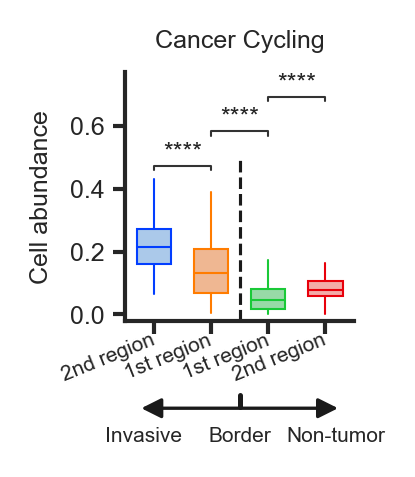

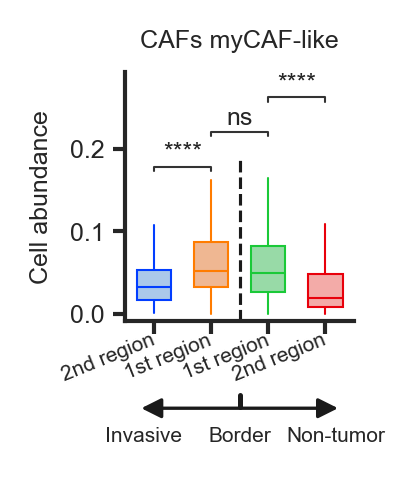

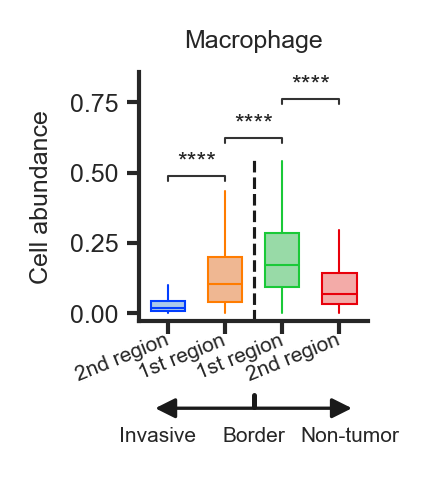

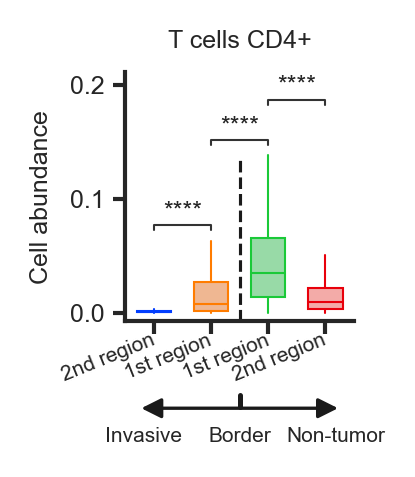

In [208]:
# cell type
cts = ['Cancer Cycling','CAFs myCAF-like','Macrophage', 'T cells CD4+']
for ct in cts:
    plot_show(df_cell_type_frac_regs,ct,fig_size=(utils.centimeter*2.5, utils.centimeter*4.2))
    plt.savefig(os.path.join(wk_root, f'notebook/results/IDC/border_celltype_{ct}.pdf'), bbox_inches='tight', format='pdf', dpi=400)

In [150]:
df_cell_type_frac_regs

,B cells Memory,B cells Naive,CAFs MSC iCAF-like,CAFs myCAF-like,Cancer Basal SC,Cancer Cycling,Cancer Her2 SC,Cancer LumA SC,Cancer LumB SC,Cycling PVL,...,Monocyte,Myoepithelial,NK cells,NKT cells,PVL Differentiated,PVL Immature,Plasmablasts,T cells CD4+,T cells CD8+,region
0,0.005344,0.012767,0.002247,0.020149,0.082667,0.157942,0.091770,0.176522,0.127056,0.000621,...,0.007239,0.051800,0.001531,0.000294,0.002571,0.000628,0.000550,0.001145,0.000379,8-4
1,0.000777,0.003752,0.000165,0.013823,0.097554,0.143440,0.117441,0.209384,0.179617,0.000460,...,0.000353,0.033166,0.000750,0.000133,0.001405,0.000311,0.000046,0.000356,0.000152,8-4
2,0.001067,0.001788,0.000154,0.040597,0.078028,0.349638,0.075660,0.184352,0.073970,0.000941,...,0.001339,0.040212,0.001888,0.000360,0.000811,0.000413,0.000133,0.000185,0.000177,8-4
3,0.000955,0.000650,0.000316,0.041427,0.068370,0.384617,0.058191,0.211084,0.030324,0.001090,...,0.000945,0.063396,0.000687,0.000169,0.000860,0.000341,0.002481,0.000218,0.000279,8-4
4,0.000263,0.001078,0.000101,0.029967,0.092086,0.262447,0.087387,0.220120,0.110731,0.001081,...,0.000420,0.050346,0.000884,0.000128,0.001527,0.000188,0.000089,0.000255,0.000191,8-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,0.001515,0.000232,0.002814,0.017393,0.077776,0.138180,0.103842,0.227400,0.155931,0.001043,...,0.001213,0.007306,0.001686,0.004770,0.004391,0.002216,0.030135,0.005277,0.003597,-4--8
971,0.000954,0.000167,0.002133,0.023328,0.099555,0.162608,0.123039,0.195791,0.158514,0.000227,...,0.001392,0.030985,0.000592,0.000364,0.002741,0.001564,0.009841,0.000738,0.000456,-4--8
972,0.002765,0.000673,0.007243,0.039796,0.083231,0.134694,0.083144,0.174597,0.100497,0.001907,...,0.002476,0.034274,0.001422,0.011565,0.007797,0.004646,0.051157,0.009940,0.002821,-4--8
973,0.006583,0.003022,0.007184,0.052114,0.066559,0.063191,0.111935,0.128504,0.092926,0.001515,...,0.004116,0.014109,0.001270,0.009621,0.001424,0.002012,0.124226,0.015026,0.007605,-4--8


# Gene

In [113]:
# gene
adas = [adata_p84, adata_p4b, adata_bn4, adata_n48]
dist_lab = ['8-4','4-b','b--4','-4--8']

gene_exp=None
for i, ada in enumerate(adas):
    gene_exp1 = ada.to_df()
    gene_exp1['region'] = [dist_lab[i]] * gene_exp1.shape[0]
    
    if i==0:
        gene_exp = gene_exp1
    else:
        gene_exp = pd.concat([gene_exp, gene_exp1], ignore_index=True)

In [66]:
gene_exp

,AL627309.1,AL627309.5,LINC01409,LINC01128,LINC00115,FAM41C,AL645608.2,LINC02593,SAMD11,NOC2L,...,MT-CYB,BX004987.1,AC145212.1,MAFIP,AC011043.1,AL354822.1,AL592183.1,AC240274.1,AC007325.4,region
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.635062,1.297851,...,3.774661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,8-4
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.434102,0.735800,...,3.562331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,8-4
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.552529,0.000000,0.000000,...,3.417912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,8-4
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,3.981913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,8-4
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,3.760241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,8-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1071,0.0,0.0,0.0,0.953488,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,4.039819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.953488,-4--8
1072,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,3.863145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-4--8
1073,0.0,0.0,0.0,0.744519,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,4.192987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-4--8
1074,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,3.957081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-4--8


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

8-4 vs. 4-b: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.595e-01 U_stat=4.747e+04
4-b vs. b--4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.156e-03 U_stat=4.940e+04
b--4 vs. -4--8: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.329e-01 U_stat=2.196e+04


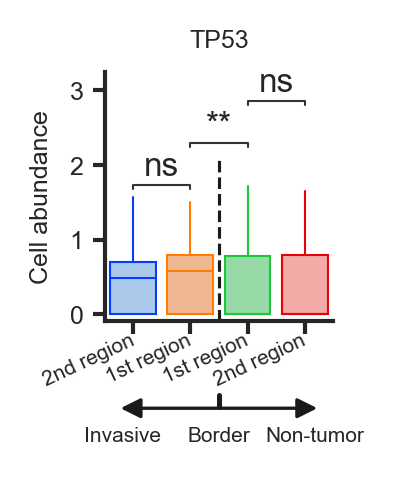

In [194]:
plot_show(gene_exp,'TP53',fig_size=(utils.centimeter*2.5, utils.centimeter*4.2))

# Hallmark

In [228]:
regions = ['8-4', '4-b','b--4','-4--8'] # normal to tumor
hallmark_pf = None
for i, _region in enumerate(regions):
    _df = pd.read_csv(f'20230302_IDC_GSVA_border_{_region}.csv').T
    new_header = _df.iloc[0] #grab the first row for the header
    _df = _df[1:] #take the data less the header row
    _df.columns = new_header #set the header row as the df header
    _df['region']=[_region]*_df.shape[0]
    if i == 0:
        hallmark_pf = _df
    else:
        hallmark_pf = pd.concat([hallmark_pf, _df], ignore_index=True)

In [229]:
hallmark_pf

Pathway,ADIPOGENESIS,ALLOGRAFT_REJECTION,ANDROGEN_RESPONSE,ANGIOGENESIS,APICAL_JUNCTION,APICAL_SURFACE,APOPTOSIS,BILE_ACID_METABOLISM,CHOLESTEROL_HOMEOSTASIS,COAGULATION,...,REACTIVE_OXYGEN_SPECIES_PATHWAY,SPERMATOGENESIS,TGF_BETA_SIGNALING,TNFA_SIGNALING_VIA_NFKB,UNFOLDED_PROTEIN_RESPONSE,UV_RESPONSE_DN,UV_RESPONSE_UP,WNT_BETA_CATENIN_SIGNALING,XENOBIOTIC_METABOLISM,region
0,-0.153874,-0.492742,-0.183788,-0.115819,-0.097936,0.108007,-0.159018,0.019207,-0.338159,-0.282773,...,-0.136687,-0.069862,-0.097323,-0.214765,-0.211036,-0.025786,-0.236717,0.095561,-0.208048,8-4
1,-0.193961,-0.524487,-0.000414,-0.305538,-0.321199,0.224283,-0.314914,0.102193,-0.072735,-0.409499,...,-0.148724,-0.000588,-0.487057,-0.123547,0.006997,-0.061003,-0.252572,-0.12075,-0.182745,8-4
2,-0.016028,-0.449249,0.15045,-0.262078,-0.196956,-0.340109,-0.079217,0.090102,-0.042273,-0.314273,...,-0.461554,0.112813,-0.052123,-0.15409,-0.014153,-0.180402,-0.188504,-0.067156,-0.148227,8-4
3,-0.256825,-0.497029,-0.065428,0.024698,-0.123785,-0.235858,-0.20702,-0.223599,0.049323,-0.321948,...,-0.227481,0.026901,-0.131144,-0.399991,-0.281622,-0.238572,-0.306395,-0.027886,-0.179441,8-4
4,-0.058072,-0.535652,-0.144684,0.286681,-0.117911,-0.037874,-0.204444,0.126764,-0.149484,-0.441596,...,-0.260148,-0.237063,-0.258372,-0.322199,-0.119827,0.058534,-0.225301,-0.315798,-0.202693,8-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,-0.158701,-0.404503,0.038436,-0.183994,-0.239854,-0.194117,-0.194477,0.012651,-0.164287,-0.321561,...,-0.308154,-0.018263,-0.377211,-0.312918,-0.264021,-0.20721,-0.188126,-0.192356,-0.254394,-4--8
971,-0.134857,-0.534161,-0.148075,-0.266332,-0.260116,-0.039038,-0.171105,0.003121,0.209006,-0.322101,...,-0.356886,0.142634,-0.241925,-0.182994,-0.184604,-0.203494,-0.233844,-0.248002,-0.294655,-4--8
972,-0.025926,-0.518692,-0.019214,-0.003223,-0.075398,0.043768,-0.229252,-0.012875,-0.239481,-0.287093,...,-0.43384,0.157548,-0.283948,-0.199644,-0.142629,-0.221555,-0.163891,-0.150798,-0.141503,-4--8
973,0.000873,-0.373534,0.051704,-0.013099,-0.121802,0.127351,-0.011147,0.169856,0.011932,-0.270155,...,-0.338567,0.004776,0.016566,-0.068162,-0.267393,0.012651,-0.218933,-0.065513,-0.151093,-4--8


In [230]:
hallmark_pf.columns

Index(['ADIPOGENESIS', 'ALLOGRAFT_REJECTION', 'ANDROGEN_RESPONSE',
       'ANGIOGENESIS', 'APICAL_JUNCTION', 'APICAL_SURFACE', 'APOPTOSIS',
       'BILE_ACID_METABOLISM', 'CHOLESTEROL_HOMEOSTASIS', 'COAGULATION',
       'COMPLEMENT', 'DNA_REPAIR', 'E2F_TARGETS',
       'EPITHELIAL_MESENCHYMAL_TRANSITION', 'ESTROGEN_RESPONSE_EARLY',
       'ESTROGEN_RESPONSE_LATE', 'FATTY_ACID_METABOLISM', 'G2M_CHECKPOINT',
       'GLYCOLYSIS', 'HEDGEHOG_SIGNALING', 'HEME_METABOLISM', 'HYPOXIA',
       'IL2_STAT5_SIGNALING', 'IL6_JAK_STAT3_SIGNALING',
       'INFLAMMATORY_RESPONSE', 'INTERFERON_ALPHA_RESPONSE',
       'INTERFERON_GAMMA_RESPONSE', 'KRAS_SIGNALING_DN', 'KRAS_SIGNALING_UP',
       'MITOTIC_SPINDLE', 'MTORC1_SIGNALING', 'MYC_TARGETS_V1',
       'MYC_TARGETS_V2', 'MYOGENESIS', 'NOTCH_SIGNALING',
       'OXIDATIVE_PHOSPHORYLATION', 'P53_PATHWAY', 'PANCREAS_BETA_CELLS',
       'PEROXISOME', 'PI3K_AKT_MTOR_SIGNALING', 'PROTEIN_SECRETION',
       'REACTIVE_OXYGEN_SPECIES_PATHWAY', 'SPERMATOGENES

In [231]:
hallmarks = ['APOPTOSIS','G2M_CHECKPOINT','TNFA_SIGNALING_VIA_NFKB',
             'GLYCOLYSIS','HYPOXIA']

camp_pairs = [[('4-b','b--4')], [('8-4','4-b')], [('8-4','4-b'),('4-b','b--4')],
              [('8-4','4-b'),('4-b','b--4'),('b--4','-4--8')], [('8-4','4-b'),('4-b','b--4')]]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

4-b vs. b--4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.886e-03 U_stat=4.297e+04
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

8-4 vs. 4-b: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.317e-03 U_stat=5.723e+04
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

8-4 vs. 4-b: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.903e-04 U_stat=5.850e+04
4-b vs. b--4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.221e

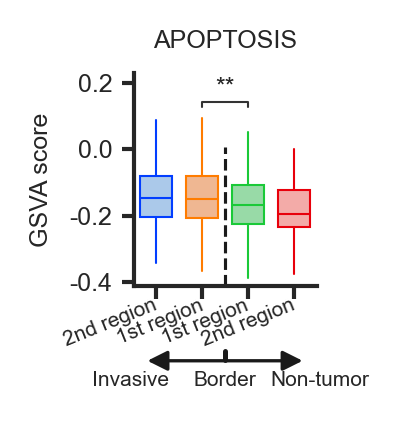

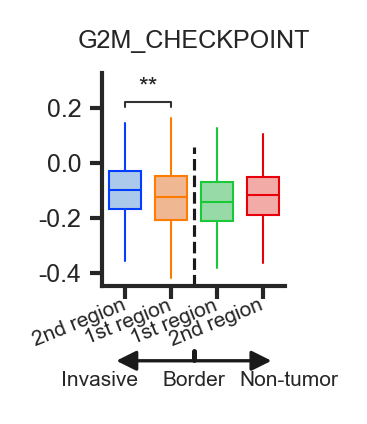

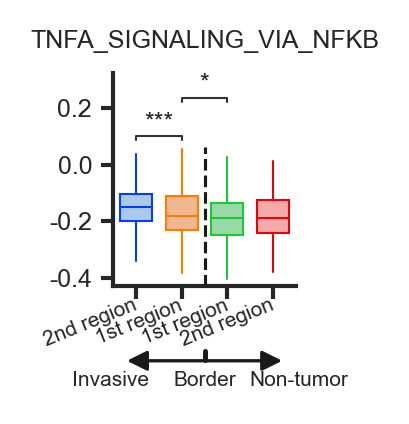

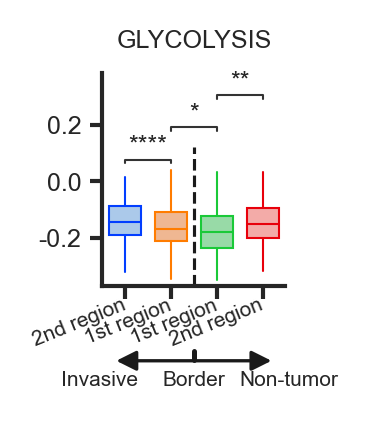

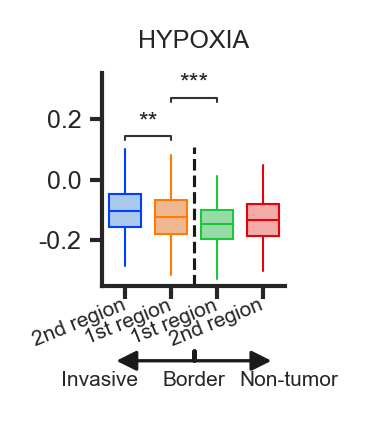

In [232]:
for i,hm in enumerate(hallmarks):
    plot_show(hallmark_pf,hm,fig_size=(utils.centimeter*2, utils.centimeter*3.6
                                      ),comp_pairs=camp_pairs[i], y_label='GSVA score' if i==0 else '')
    plt.savefig(os.path.join(wk_root, f'notebook/results/IDC/hallmark_{hm}.pdf'), bbox_inches='tight', format='pdf', dpi=400)

# Estimate score

In [221]:
regions = ['8-4', '4-b','b--4','-4--8'] # normal to tumor

estimate_pf = None
for i, _region in enumerate(regions):
    _df = pd.read_csv(f'IDC_Estimate_score_border_{_region}.csv')
    _df['region']=[_region]*_df.shape[0]
    if i == 0:
        estimate_pf = _df
    else:
        estimate_pf = pd.concat([estimate_pf, _df], ignore_index=True)

In [222]:
estimate_pf

,Samples,StromalScore,ImmuneScore,ESTIMATEScore,TumorPurity,region
0,AAACAGGGTCTATATT.1,231.741866,206.954057,438.695923,0.784205,8-4
1,AAACCTAAGCAGCCGG.1,-404.965557,-163.244361,-568.209918,0.867033,8-4
2,AAACGGGCGTACGGGT.1,-27.175191,-0.308499,-27.483690,0.824797,8-4
3,AAACTCGGTTCGCAAT.1,-94.452628,286.337153,191.884525,0.806166,8-4
4,AAAGAATGTGGACTAA.1,-28.324209,102.784178,74.459969,0.816244,8-4
...,...,...,...,...,...,...
970,TTATTAGAGCGTGTTC.1,374.268829,791.725071,1165.993900,0.713622,-4--8
971,TTATTATCTGGAAGGC.1,181.334740,466.188225,647.522964,0.764819,-4--8
972,TTCCGCGTGAGGCGAT.1,183.099997,564.494982,747.594978,0.755273,-4--8
973,TTCTGACCGGGCTCAA.1,332.297435,838.533807,1170.831242,0.713124,-4--8


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

8-4 vs. 4-b: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.161e-43 U_stat=1.872e+04
4-b vs. b--4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.783e-15 U_stat=2.290e+04
b--4 vs. -4--8: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.569e-12 U_stat=1.877e+04
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

8-4 vs. 4-b: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.744e-33 U_stat=2.253e+04
4-b vs. b--4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.983e-13 U_stat=2.392e+04
b--4 vs. -4--8: Mann-Whitney-Wilcoxon 

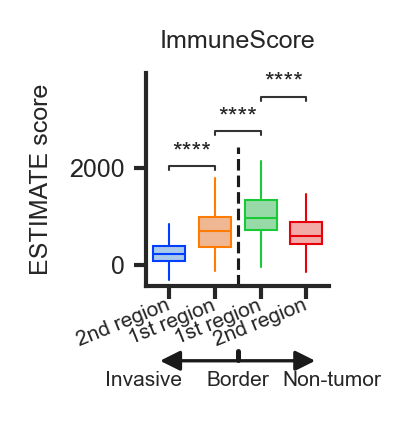

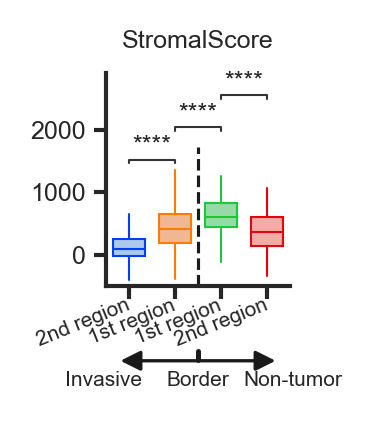

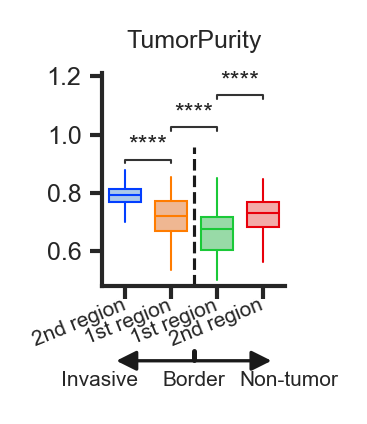

In [233]:
scores = ['ImmuneScore','StromalScore','TumorPurity']
for i,s in enumerate(scores):
    plot_show(estimate_pf,s,fig_size=(utils.centimeter*2, utils.centimeter*3.6
                                      ),comp_pairs='all', y_label='ESTIMATE score' if i==0 else '')
    plt.savefig(os.path.join(wk_root, f'notebook/results/IDC/estimate_{s}.pdf'), bbox_inches='tight', format='pdf', dpi=400)